In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import odom_utils as odou
from visualization import papermode

# papermode(plt, size=18)


In [2]:
preprocess("R08", verbose=False)
preprocess("R10", verbose=False)
m2009df = pd.concat(
    [
        morales2009.morales2009("R08", verbose=False),
        morales2009.morales2009("R10", verbose=False),
    ],
    ignore_index=True,
).rename(columns={"long":"lon"})
p2014df = pd.concat(
    [
        pentzer2014pow.pentzer2014pow("R08", verbose=False),
        pentzer2014pow.pentzer2014pow("R10", verbose=False),
    ],
    ignore_index=True,
).rename(columns={"long":"lon"})
p2022df = pd.concat(
    [
        pentzer2022.pentzer2022("R08", verbose=False),
        pentzer2022.pentzer2022("R10", verbose=False),
    ],
    ignore_index=True,
).rename(columns={"long":"lon"})
figdir = u.get_figdir("summary", subdir=f"maps")


R10: 100%|██████████| 1152/1152 [00:00<00:00, 5633.66it/s]


# Cartopy

In [3]:
import cartopy.io.img_tiles as cimgt
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


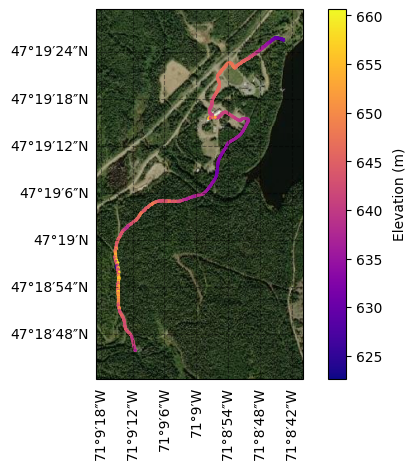

In [4]:
tiler = cimgt.GoogleTiles(
    url="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)

fig, ax = plt.subplots(subplot_kw={"projection": tiler.crs})

gl = ax.gridlines(
    draw_labels=True,
    color="k",
    alpha=0.4,
    linestyle="--",
    dms=True,
    x_inline=False,
    y_inline=False,
)
gl.xlabel_style = {'rotation': 90}
gl.top_labels = gl.right_labels = False
ax.xaxis.set_major_formatter(LatitudeFormatter(dms=True))
ax.yaxis.set_major_formatter(LongitudeFormatter(dms=True))

coords = p2022df[["lon", "lat"]].copy()

extent = [
    coords.lon.min() - 1e-3,
    coords.lon.max() + 1e-3,
    coords.lat.min() - 1e-3,
    coords.lat.max() + 1e-3,
]

ax.set_extent(extent)
ax.add_image(tiler, 15)

cseries = p2022df.alt
cm = plt.get_cmap("plasma")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

sc = ax.scatter(m2009df.lon, m2009df.lat, c=scmap.to_rgba(m2009df.alt), s=1, transform=ccrs.PlateCarree())

# fig.tight_layout()
# cbar_ax = fig.add_axes([0.9, 0.1, 0.1, 0.8])
# cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
cbar = fig.colorbar(scmap, ax=ax)
cbar.ax.set_ylabel("Elevation (m)")
cbar.ax.yaxis.set_label_position("right")
cbar.ax.yaxis.set_label_coords(3.5, 0.5)
